Assume you have a PGM with a few variables A, B, C.

A->C, B->C

Assume

`
A ~ Bern(.7)
B ~ Bern(.4)
C|A0,B0 ~ Categorical(.3, .7, 0)
C|A0,B1 ~ Categorical(0, .9, .1)
C|A1,B0 ~ Categorical(.3, .3, .4)
C|A1,B1 ~ Categorical(.5, .2, .3)
`

Can you perform exact inference with either edward or pymc3 to calculate P(C)?

Can you calculate P(C|A=0)

Related

* https://github.com/pymc-devs/pymc3/issues/1790
* https://gist.github.com/tbsexton/1349864212b25cce91dbe5e336d794b4

### pymc3

In [3]:
import pymc3 as pm
import theano
import theano.tensor as T
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [33]:
with pm.Model() as m:
    
    a = pm.Bernoulli('A', .7) 
    b = pm.Bernoulli('B', .4)
    c00 = pm.Categorical('C00', T.stack([.3, .7, 0.]))
    c01 = pm.Categorical('C01', T.stack([0., .9, .1]))
    c10 = pm.Categorical('C10', T.stack([.3, .3, .4]))
    c11 = pm.Categorical('C11', T.stack([.5, .2, .3]))

    pa0 = pm.math.switch(theano.tensor.eq(a,0), .7, .3) #prob A=0
    pb0 = pm.math.switch(theano.tensor.eq(b,0), .4, .6) #prob B=0

    #can use this to infer p(c)
    c = pm.Deterministic('C', T.switch(T.eq(a,0), T.switch(T.eq(b,0), c00, c01), T.switch(T.eq(b,0), c10, c11)))
    
    #todo: p(c|A=0)
    #you have samples from A
    #you have samples from C.  
    #Remove all samples where A=1 and find existing results.
    
    #is there a more bayesian approach then what's listed above?
    
    
    

/Users/larsonte/anaconda3/envs/keras2/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [24]:
with m: 
    #map_estimate = pm.find_MAP()
    trace = pm.sample(draws=5000)

Assigned BinaryGibbsMetropolis to A
Assigned BinaryGibbsMetropolis to B
Assigned CategoricalGibbsMetropolis to C00
Assigned CategoricalGibbsMetropolis to C01
Assigned CategoricalGibbsMetropolis to C10
Assigned CategoricalGibbsMetropolis to C11
100%|██████████| 5000/5000 [00:06<00:00, 726.28it/s]


In [25]:
trace.varnames


['A', 'B', 'C00', 'C01', 'C10', 'C11', 'C']

In [26]:
#infering p(C)

#forward sampling loop
cCounts = [0,0,0]
for i in range(len(trace)):
    t = trace[i]
    if t['A'] == 0 and t['B'] == 0:
        idx = t['C00']
    elif t['A'] == 0 and t['B'] == 1:
        idx = t['C01']
    elif t['A'] == 1 and t['B'] == 0:
        idx = t['C10']
    elif t['A'] == 1 and t['B'] == 1:
        idx = t['C11']
    cCounts[idx]+=1

In [18]:
cCounts

[314, 413, 273]

In [27]:
#once you figure out how to implement cv try seeing what happens when you sample that. 
pm.summary(trace, varnames=['C'], start=500)


C:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.948            0.762            0.011            [0.000, 2.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          1.000          2.000          2.000



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117472668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1181f8908>]], dtype=object)

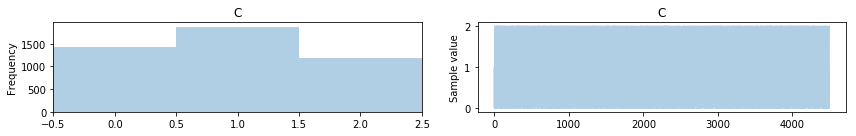

In [28]:
pm.traceplot(trace[500:], varnames=['C'])


In [29]:
trace['C'][:10]

array([0, 1, 2, 1, 1, 0, 2, 2, 2, 1])

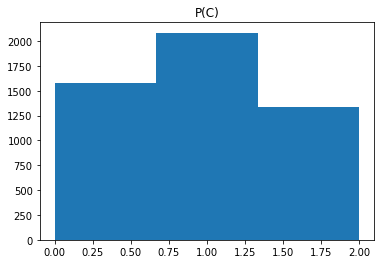

In [30]:
#best to just plot a simple histogram
plt.title("P(C)")
h = plt.hist(trace["C"], bins=3, histtype="stepfilled")

In [32]:
counts = np.bincount(trace['C'])
np.true_divide(counts, len(trace))

array([ 0.3164,  0.4168,  0.2668])

The above is really close to what we got before.

### Edward

In [ ]:
#check out the Deep probabilistic programming paper, section 4.1.  